In [1]:
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# print x random images from the given dataset
def print_x_images_from_ds(dataset, number_images):
    fig, ax = plt.subplots(1,number_images, figsize=(30, 20))
    for i, (image, label) in enumerate(dataset.take(number_images)):
    ax[i].imshow(image)
    ax[i].set_title(f'Shape = {image.shape}')
    ax[i].axis('off')

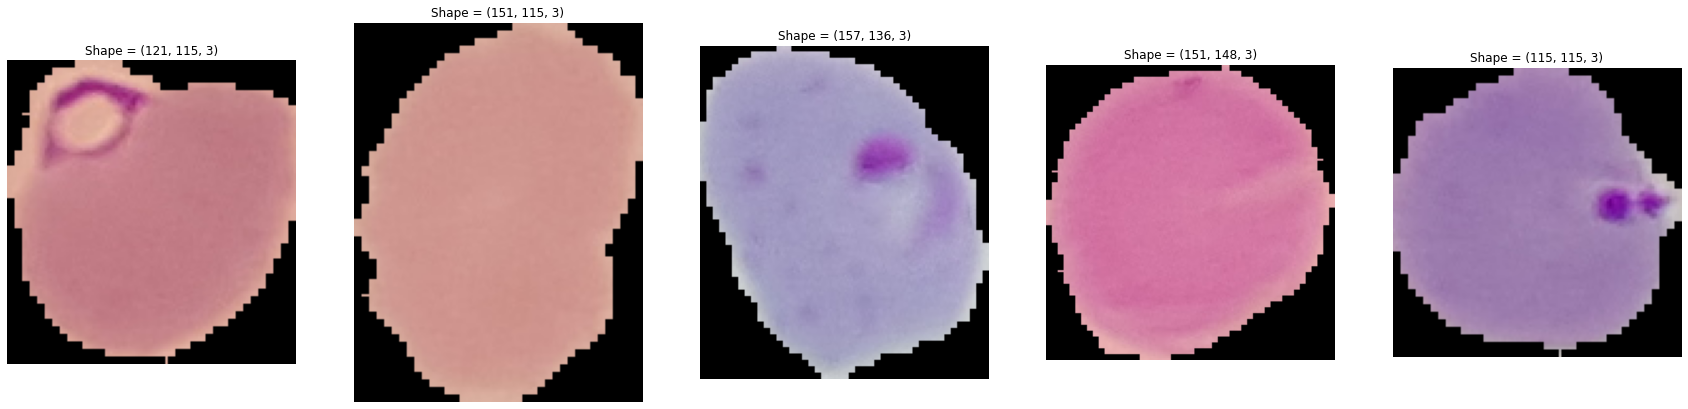

In [3]:
# load first 80% as training and rest as testing data
train_data, test_data= tfds.load('malaria', split=['train[:80%]', 'train[-20%:]'], shuffle_files=True, as_supervised=True)

# take a first look at some images before preprocessing
print_x_images_from_ds(train_data, 5)

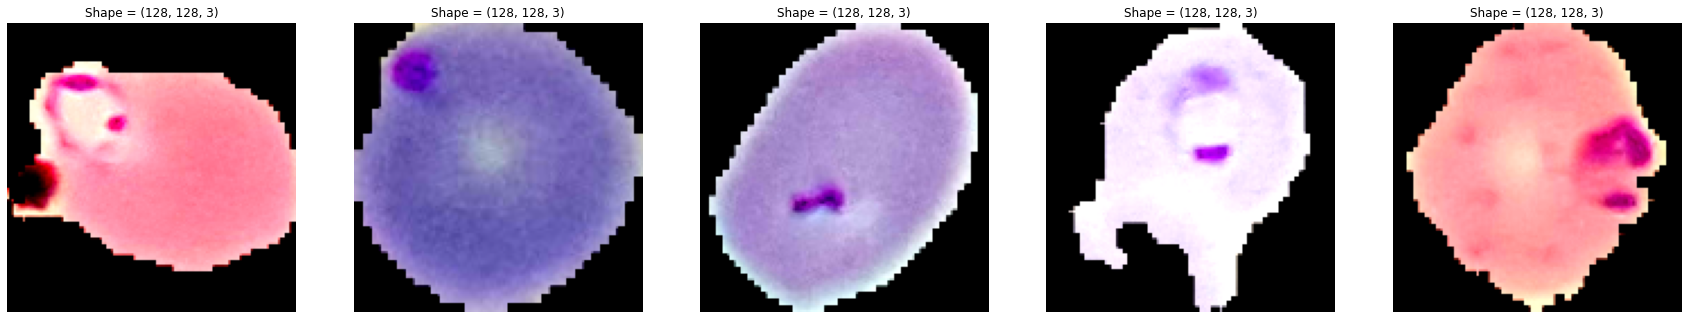

In [4]:
# resize images and one_hotify targets
train_data = train_data.map(lambda sample, target: (tf.image.resize_with_pad(sample,128,128), tf.one_hot(target,depth=1)))
# normalize images
train_data = train_data.map(lambda sample, target: (tf.image.per_image_standardization(sample), target))

# print some images after normalization, the shapes are now all the same
print_x_images_from_ds(train_data, 5)

# batch and prefetch
train_data = train_data.batch(64)
train_data = train_data.prefetch(32)

# do the same with test data
test_data = test_data.map(lambda sample, target: (tf.image.resize_with_pad(sample,128,128), tf.one_hot(target,depth=1)))
test_data = test_data.map(lambda sample, target: (tf.image.per_image_standardization(sample), target))
test_data = test_data.batch(64)
test_data = test_data.prefetch(32)

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the layers.
        self.conv_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,
                                               activation=tf.keras.activations.relu, input_shape = (128,128,3)
                                               )
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.conv_2 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3,
                                               activation=tf.keras.activations.relu
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D()
        self.conv_3 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3,
                                               activation=tf.keras.activations.relu
                                               )
        self.max_pool_3 = tf.keras.layers.MaxPool2D()
        self.conv_4 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3,
                                               activation=tf.keras.activations.relu
                                               )
        self.max_pool_4 = tf.keras.layers.MaxPool2D()
        self.conv_5 = tf.keras.layers.Conv2D(filters = 1024, kernel_size = 3,
                                               activation=tf.keras.activations.relu
                                               )
        self.max_pool_5 = tf.keras.layers.MaxPool2D()

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer = tf.keras.layers.Dense(1,
                                                  activation = tf.keras.activations.sigmoid
                                                  )

    def call(self, x):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.conv_4(x)
        x = self.max_pool_4(x)
        x = self.conv_5(x)
        x = self.max_pool_5(x)
        x = self.global_pool(x)
        x = self.output_layer(x)

        return x

In [6]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        
        # compute mean of fitting preditions in this batch
        sample_test_accuracy = np.mean(abs(target - prediction) < 0.5)
        
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [7]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 25
learning_rate = 0.00001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_data, binary_crossentropy)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_data, binary_crossentropy)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_data = train_data.shuffle(buffer_size=128)
    test_data = test_data.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data:
        train_loss = train_step(model, input, target, binary_crossentropy, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_data, binary_crossentropy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24


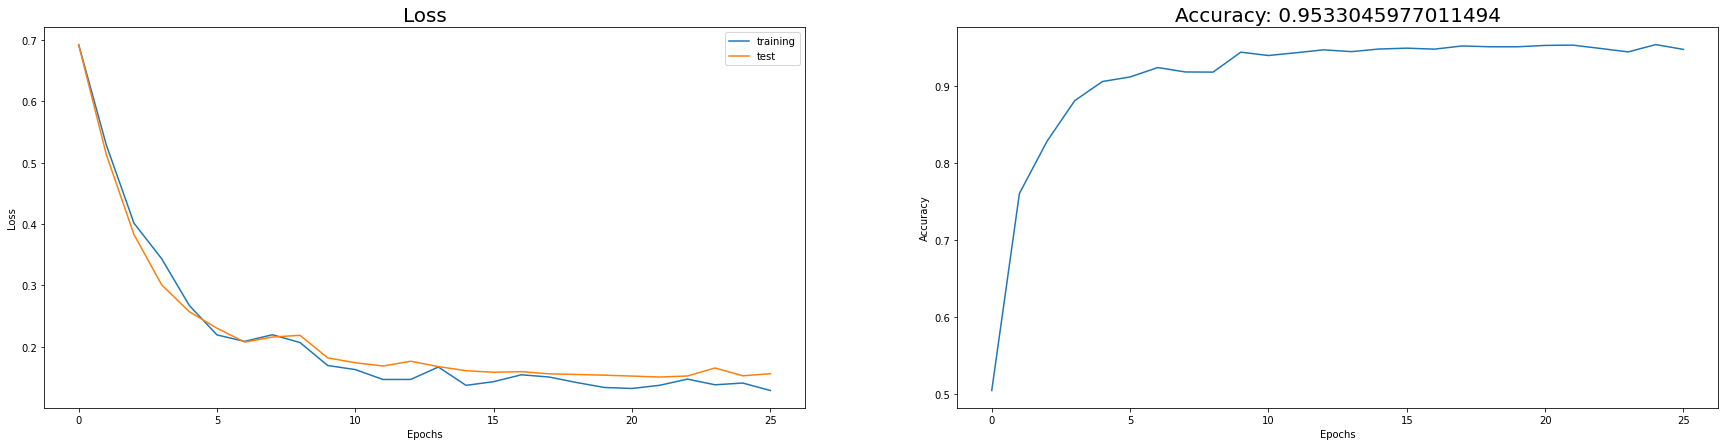

In [8]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,7))
axes[0].plot(train_losses, label="training")
axes[0].plot(test_losses, label="test")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss", fontsize=20)
axes[0].legend()
axes[1].plot(test_accuracies)
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy: " + str(np.max(test_accuracies)), fontsize=20)
plt.show()